# Intro

Same as Andrej Karpathy's [`demo.ipynb`](https://github.com/karpathy/micrograd/blob/master/demo.ipynb) in `micrograd`

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from neev.engine import Value
from neev.nn import Neuron, Layer, MLP

In [ ]:
np.random.seed(1337)
random.seed(1337)

<matplotlib.collections.PathCollection>

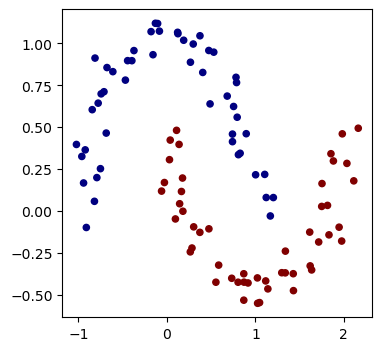

In [ ]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(4,4))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [ ]:
X[0:2]

array([[ 1.12211461,  0.08147717],
       [-0.81882941,  0.05879006]])

In [ ]:
y[:2]

array([-1, -1])

In [ ]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [ ]:
# loss function
def loss(batch_size=None):
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

In [ ]:
total_loss, acc = loss()
print(total_loss, acc)

Value(data=1.1815924818239036, grad=0) 0.5


[<matplotlib.lines.Line2D>]

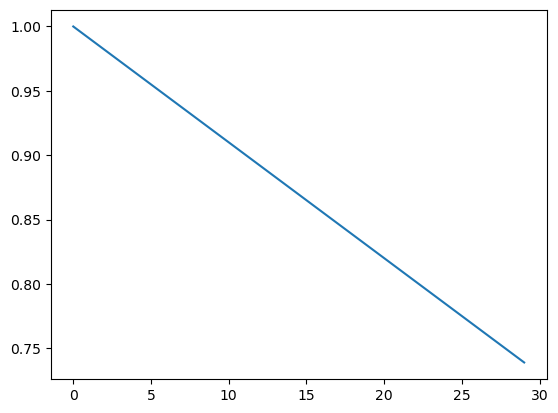

In [ ]:
plt.plot(range(30), 
         [1.0 - 0.9*k/100 for k in range(30)]
        )

In [ ]:
# optimization
k,total_loss, acc = None, None, None
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 10 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")
        
print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")        

step 0 loss 1.1815924818239036, accuracy 50.0%
step 10 loss 0.31760386828043347, accuracy 89.0%
step 20 loss 0.22577744378801215, accuracy 92.0%
step 30 loss 0.3502788739962499, accuracy 89.0%
step 40 loss 0.09745912726682801, accuracy 95.0%
step 50 loss 0.05243801242621, accuracy 99.0%
step 60 loss 0.03698901868193646, accuracy 100.0%
step 70 loss 0.018699428103430657, accuracy 100.0%
step 80 loss 0.01668851960696719, accuracy 100.0%
step 90 loss 0.014652049002652014, accuracy 100.0%
step 99 loss 0.01352435799993185, accuracy 100.0%


In [ ]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]

In [ ]:
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))

In [ ]:
inputs[0]

[Value(data=-2.0221939055140945, grad=0),
 Value(data=-1.548639298268643, grad=0)]

In [ ]:
scores[0]

Value(data=-4.784904563750659, grad=0)

In [ ]:
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

In [ ]:
Z[0]

array([False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

(-1.548639298268643, 1.951360701731357)

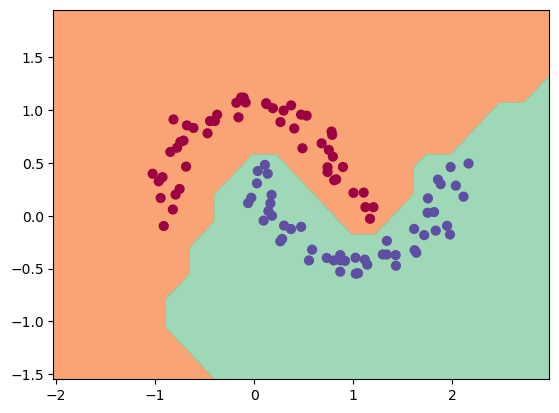

In [ ]:
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())